# Ensemble Model - EDP

### Author - Shaurya Singh Srinet and Charvi Jain

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import gdown
import cv2
import shutil
import math
from glob import glob
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall


C:\Users\Shaurya\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Reading input data

In [2]:
input_directory = r"C:\Users\Shaurya\Desktop\RetinaXpert\dataset"

for dirname, _, filenames in os.walk(input_directory):
        print("Dataset Accessed from Local Machine")


Dataset Accessed from Local Machine
Dataset Accessed from Local Machine
Dataset Accessed from Local Machine
Dataset Accessed from Local Machine
Dataset Accessed from Local Machine


### Data Distribution Graph

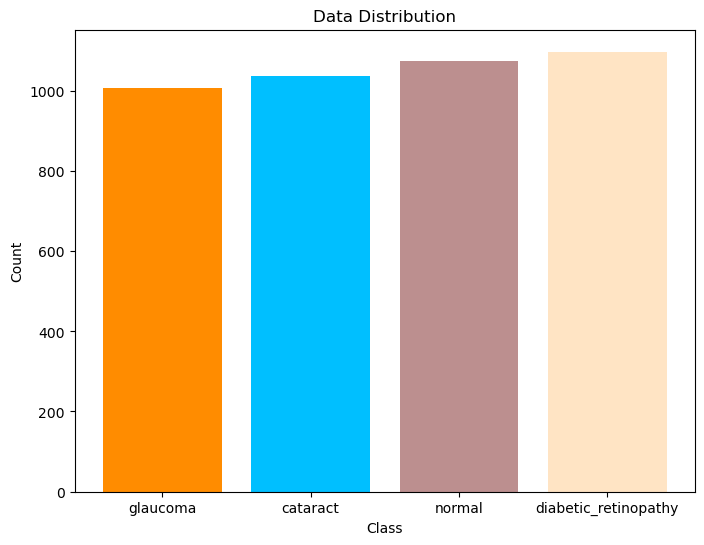

In [3]:
import matplotlib.pyplot as plt
class_names = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"]
# Count for each class
count_for_class_0 = 1007
count_for_class_1 = 1038
count_for_class_2 = 1074
count_for_class_3 = 1098

# Creating a list with the counts
class_counts = [count_for_class_0, count_for_class_1, count_for_class_2, count_for_class_3]

# Defining colors for the bar graph
colors = ['darkorange', 'deepskyblue', 'rosybrown', 'bisque']

# Creating a bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=colors)

# Adding labels and a title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Data Distribution")

plt.show()


### Making Dataframes

In [4]:
sdir = r"C:\Users\Shaurya\Desktop\RetinaXpert\dataset"


def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          ' the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df


train_df, test_df, valid_df = make_dataframes(sdir=sdir)

normal                 : 100%|██████████████████████████████████████████| 1074/1074 [00:11<00:00, 94.20file/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  878  the minimum files in any class in train_df is  806
train_df length:  3373   test_df length:  422   valid_df length:  422
average image height=  430   average image width=  430  aspect ratio h/w=  1.0


### Creating Data using ImageGenerator

In [5]:
batch_size = 64
img_height, img_width = 300, 300
img_size = (img_height, img_width)
input_shape = (img_height, img_width, 3)

def create_data(batch_size, train_df, test_df, valid_df, img_size):
    train_gen = ImageDataGenerator(rescale=1/255.0, rotation_range=20, vertical_flip=True, shear_range=0.2, dtype=float)
    test_gen = ImageDataGenerator(rescale=1/255.0, dtype=float)
    
    train_set = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    test_set = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    val_set = test_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    
    return train_set, test_set, val_set


train_set, test_set, val_set = create_data(batch_size, train_df, test_df, valid_df, img_size)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


### Label Mapping

In [6]:
label_dict = {v:k for k,v in train_set.class_indices.items()}
label_dict

{0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}

### Initializing model generating and callback function

In [7]:
# Function to generate the VGG16 model
def generate_vgg16_model(input_shape, num_classes, name=None):
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    vgg16_base.trainable = False
    
    model = Sequential([
        vgg16_base,
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=num_classes, activation='softmax')
    ], name=name)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[CategoricalAccuracy(), Precision(), Recall()])
    
    return model

### Function to generate callbacks

In [8]:
def generate_callbacks(model):
    checkpoint = ModelCheckpoint(filepath='VGG16_best_model.h5',
                                 save_best_only=True,
                                 save_weights_only=True)
    return [checkpoint]

### Split the data into training and testing sets for each class

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your data
data_path = "C:\\Users\\Shaurya\\Desktop\\RetinaXpert\\dataset"

# Get the list of classes (subdirectories)
class_names = os.listdir(data_path)

# Create directories for the train and test sets
train_path = 'C:/Users/Shaurya/Desktop/RetinaXpert/train'
test_path = 'C:/Users/Shaurya/Desktop/RetinaXpert/test'

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_name in class_names:
    class_path = os.path.join(data_path, class_name)
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    class_files = os.listdir(class_path)
    train_files, test_files = train_test_split(class_files, test_size=0.2, random_state=42)

    for file in train_files:
        os.replace(os.path.join(class_path, file), os.path.join(train_class_path, file))

    for file in test_files:
        os.replace(os.path.join(class_path, file), os.path.join(test_class_path, file))

# Assuming you have an input_shape defined for your data
input_shape = (224, 224, 3)

# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Load the data using flow_from_directory
train_set = train_datagen.flow_from_directory(train_path,
                                             target_size=input_shape[:2],
                                             batch_size=batch_size,
                                             class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                           target_size=input_shape[:2],
                                           batch_size=batch_size,
                                           class_mode='categorical')

Found 3372 images belonging to 4 classes.
Found 845 images belonging to 4 classes.


### Generating the VGG16 model

In [13]:
vgg16_model = generate_vgg16_model(input_shape=input_shape, num_classes=num_classes, name='custom_vgg16_model')

# Generating callbacks for the model
callbacks = generate_callbacks(vgg16_model)

# Displaying the VGG16 model summary
vgg16_model.summary()

# Set the number of epochs
epochs = 10

# Train the VGG16 model
history_vgg16 = vgg16_model.fit(train_set,
                                epochs=epochs,
                                steps_per_epoch=train_set.n // batch_size,
                                validation_data=test_set,
                                validation_steps=test_set.n // batch_size,
                                callbacks=callbacks)

58889256/58889256 [==============================] - 7s 0us/step
Model: "custom_vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                 

### Plot the training history

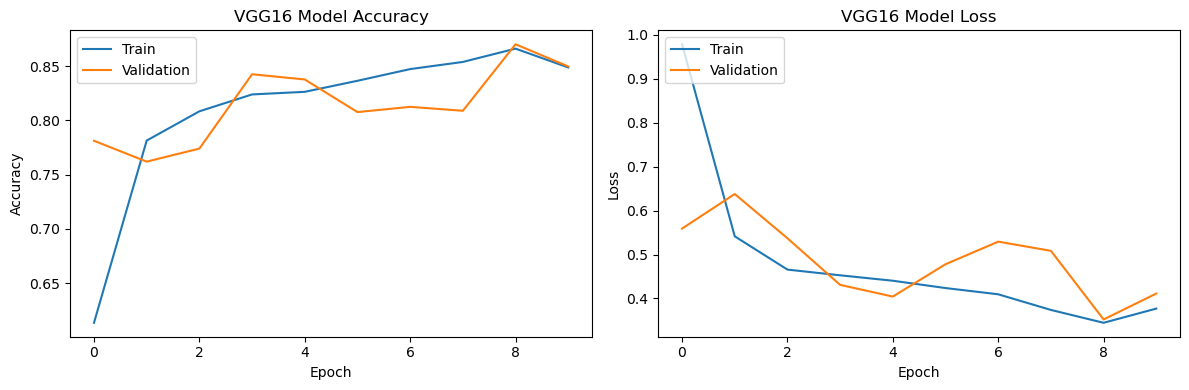

In [14]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('VGG16 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('VGG16 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history_vgg16)

### Evaluate the VGG16 model on the test set

In [15]:
evaluation_vgg16 = vgg16_model.evaluate(test_set, steps=test_set.n // batch_size)

# Print the evaluation results
print("\nEvaluation Results for VGG16 Model:")
print(f"Test Loss: {evaluation_vgg16[0]:.4f}")
print(f"Test Accuracy: {evaluation_vgg16[1]*100:.2f}%")

26/26 [==============================] - 78s 3s/step - loss: 0.4147 - categorical_accuracy: 0.8474 - precision: 0.8575 - recall: 0.8245

Evaluation Results for VGG16 Model:
Test Loss: 0.4147
Test Accuracy: 84.74%


### One-hot Encoding

In [24]:
y_true = np.argmax(test_set.classes)
y_pred = np.argmax(predictions_vgg16, axis=1)

### Generating Confusion Matrix

27/27 [==============================] - 83s 3s/step


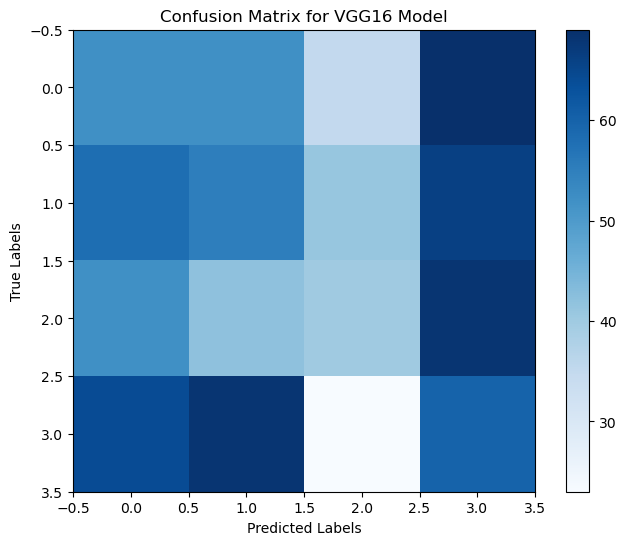

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_set.classes is one-dimensional
y_true = test_set.classes

# Assuming predictions_vgg16 is the predicted probabilities from the VGG16 model
predictions_vgg16 = vgg16_model.predict(test_set, steps=np.ceil(test_set.n / batch_size))
y_pred = np.argmax(predictions_vgg16, axis=1)

# Generate and plot the confusion matrix for VGG16 model
cm_vgg16 = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_vgg16, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for VGG16 Model')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Generating Classification Report

In [30]:
from sklearn.metrics import classification_report

# Generate and print the classification report for VGG16 model
class_labels_vgg16 = list(test_set.class_indices.keys())
print("Classification Report for VGG16 Model:")
print(classification_report(y_true, y_pred, target_names=class_labels_vgg16))

Classification Report for VGG16 Model:
                      precision    recall  f1-score   support

            cataract       0.23      0.25      0.24       208
diabetic_retinopathy       0.25      0.25      0.25       220
            glaucoma       0.29      0.20      0.23       202
              normal       0.23      0.28      0.25       215

            accuracy                           0.24       845
           macro avg       0.25      0.24      0.24       845
        weighted avg       0.25      0.24      0.24       845

